In [1]:
# !pip install scikit-fuzzy


### Importacion de librerías

In [2]:
import sim
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from dataclasses import dataclass
from typing import Dict, List, Tuple
import pandas as pd

### Creacion de clases

### Clases correspondientes a las trayectorias

In [3]:
class TrayectoriaGeometrica:

    def __init__(self, precision):
        self.precision = precision

    def lineal(self, x0, y0, x1, y1):
        x = np.linspace(x0, x1, self.precision)
        y = np.linspace(y0, y1, self.precision)
        return np.column_stack((x, y))

    def circular(self, x, y, r):
        theta = np.linspace(0, 2 * np.pi, self.precision)
        px = x + r * np.cos(theta)
        py = y + r * np.sin(theta)
        return np.column_stack((px, py))

    def rectangular(self, x0, y0, x1, y1):
        puntos = []

        # Lado inferior
        xi = np.linspace(x0, x1, self.precision, endpoint=False)
        yi = np.full_like(xi, y0)
        puntos.append(np.column_stack((xi, yi)))

        # Lado derecho
        yi = np.linspace(y0, y1, self.precision, endpoint=False)
        xi = np.full_like(yi, x1)
        puntos.append(np.column_stack((xi, yi)))

        # Lado superior
        xi = np.linspace(x1, x0, self.precision, endpoint=False)
        yi = np.full_like(xi, y1)
        puntos.append(np.column_stack((xi, yi)))

        # Lado izquierdo
        yi = np.linspace(y1, y0, self.precision)
        xi = np.full_like(yi, x0)
        puntos.append(np.column_stack((xi, yi)))

        return np.vstack(puntos)


### Conexion con copelia


In [4]:
def connect_to_coppelia():
    """Establece conexión con CoppeliaSim"""
    sim.simxFinish(-1)  # Cierra conexiones previas
    client_id = sim.simxStart('127.0.0.1', 19997, True, True, 5000, 5)
    if client_id != -1:
        print("✅ Conectado a CoppeliaSim")
    else:
        raise Exception("❌ No se pudo conectar")
    return client_id

def get_handles(client_id):
    """Obtiene los handles de los objetos del robot"""
    _, left_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_leftMotor', sim.simx_opmode_blocking)
    _, right_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_rightMotor', sim.simx_opmode_blocking)
    _, robot = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx', sim.simx_opmode_blocking)
    return left_motor, right_motor, robot

def get_robot_position(client_id, handle):
    """Obtiene posición y orientación del robot"""
    _, position = sim.simxGetObjectPosition(client_id, handle, -1, sim.simx_opmode_buffer)
    _, orientation = sim.simxGetObjectOrientation(client_id, handle, -1, sim.simx_opmode_buffer)
    return position, orientation

def set_motor_speeds(client_id, left_motor, right_motor, v_l, v_r):
    """Establece velocidades de los motores"""
    sim.simxSetJointTargetVelocity(client_id, left_motor, v_l, sim.simx_opmode_oneshot)
    sim.simxSetJointTargetVelocity(client_id, right_motor, v_r, sim.simx_opmode_oneshot)


In [5]:
def trayectoria(L, A, velTrayectoria):
    """Genera trayectoria cuadrada"""
    NptosLargo = round(L / (velTrayectoria * 0.1))
    NptosAncho = round(A / (velTrayectoria * 0.1))
    compx1 = np.linspace(0, L, NptosLargo)
    compy1 = np.linspace(0, A, NptosAncho)
    inx = compx1[1] - compx1[0]
    iny = compy1[1] - compy1[0]
    x1 = np.linspace(0, L - inx, NptosLargo)
    y1 = np.zeros_like(x1)
    y2 = np.linspace(iny, A - iny, NptosAncho)
    x2 = L * np.ones_like(y2)
    x3 = np.linspace(L - inx, inx, NptosLargo)
    y3 = A * np.ones_like(x3)
    y4 = np.linspace(A - iny, 0, NptosAncho)
    x4 = np.zeros_like(y4)
    xref = np.concatenate([x1, x2, x3, x4])
    yref = np.concatenate([y1, y2, y3, y4])
    return xref, yref


def trayectoria_circular(radio, velTrayectoria, cx=None, cy=None):
    """
    Genera trayectoria circular siguiendo el mismo estilo que trayectoria()
    
    Args:
        radio: Radio del círculo [m]
        velTrayectoria: Velocidad de la trayectoria [m/s]
        cx, cy: Centro del círculo [m] (por defecto: centro en radio, radio)
    
    Returns:
        xref, yref: Arrays de coordenadas de la trayectoria circular
    """
    # Si no se especifica centro, usar el radio como centro (círculo en primer cuadrante)
    if cx is None:
        cx = radio
    if cy is None:
        cy = radio
    
    # Calcular circunferencia total
    circunferencia = 2 * np.pi * radio
    
    # Número de puntos basado en velocidad (similar a la función original)
    Nptos = round(circunferencia / (velTrayectoria * 0.1))
    
    # Asegurar un mínimo de puntos para un círculo suave
    if Nptos < 20:
        Nptos = 20
    
    # Generar ángulos desde 0 hasta 2pi
    angulos = np.linspace(0, 2*np.pi, Nptos)
    
    # Calcular coordenadas del círculo
    xref = cx + radio * np.cos(angulos)
    yref = cy + radio * np.sin(angulos)
    
    return xref, yref


def trayectoria_lineal(x0, y0, x1, y1, velTrayectoria):
    """
    Genera trayectoria lineal entre dos puntos siguiendo el mismo estilo que trayectoria()
    
    Args:
        x0, y0: Punto inicial [m]
        x1, y1: Punto final [m]
        velTrayectoria: Velocidad de la trayectoria [m/s]
    
    Returns:
        xref, yref: Arrays de coordenadas de la trayectoria lineal
    """
    # Calcular distancia entre puntos
    distancia = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    
    # Número de puntos basado en velocidad (similar a la función original)
    Nptos = round(distancia / (velTrayectoria * 0.1))
    
    # Asegurar al menos 2 puntos
    if Nptos < 2:
        Nptos = 2
    
    # Generar coordenadas lineales
    xref = np.linspace(x0, x1, Nptos)
    yref = np.linspace(y0, y1, Nptos)
    
    return xref, yref


def normalize_angle(angle):
    """Normaliza ángulo entre -π y π"""
    return np.arctan2(np.sin(angle), np.cos(angle))




### Funcion para ver los graficos

In [6]:
def plot_results(trajectory_data, xref, yref, dt=0.05):
    """Genera gráficos de análisis del seguimiento"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Gráfico 1: Trayectoria en el plano XY
    ax1.plot(xref, yref, 'b--', linewidth=2, label='Trayectoria de referencia')
    ax1.plot(trajectory_data['x_actual'], trajectory_data['y_actual'], 'r-', linewidth=1.5, label='Trayectoria real')
    ax1.scatter(xref[0], yref[0], color='green', s=100, marker='o', label='Inicio')
    ax1.scatter(xref[-1], yref[-1], color='red', s=100, marker='s', label='Final')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Seguimiento de Trayectoria Cuadrada')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Gráfico 2: Error de distancia vs tiempo
    ax2.plot(trajectory_data['time'], trajectory_data['error_distance'], 'b-', linewidth=1.5)
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Error de Distancia (m)')
    ax2.set_title('Error de Distancia vs Tiempo')
    ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Error de orientación vs tiempo
    ax3.plot(trajectory_data['time'], trajectory_data['error_orientation'], 'g-', linewidth=1.5)
    ax3.set_xlabel('Tiempo (s)')
    ax3.set_ylabel('Error de Orientación (rad)')
    ax3.set_title('Error de Orientación vs Tiempo')
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Posición X e Y vs tiempo
    ax4.plot(trajectory_data['time'], trajectory_data['x_ref'], 'b--', label='X referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['x_actual'], 'b-', label='X real')
    ax4.plot(trajectory_data['time'], trajectory_data['y_ref'], 'r--', label='Y referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['y_actual'], 'r-', label='Y real')
    ax4.set_xlabel('Tiempo (s)')
    ax4.set_ylabel('Posición (m)')
    ax4.set_title('Posición vs Tiempo')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
        # === MÉTRICAS DE RENDIMIENTO ===
    error = np.array(trajectory_data['error_distance'])
    u_v = np.array(trajectory_data.get('v_command', []))
    u_w = np.array(trajectory_data.get('w_command', []))

    IAE = np.sum(np.abs(error)) * dt
    ISE = np.sum(error**2) * dt

    if len(u_v) > 1:
        TVu_v = np.sum(np.abs(np.diff(u_v)))
    else:
        TVu_v = 0.0

    if len(u_w) > 1:
        TVu_w = np.sum(np.abs(np.diff(u_w)))
    else:
        TVu_w = 0.0

    print("\n📊 Métricas de Rendimiento:")
    print(f"IAE (Integral of Absolute Error): {IAE:.4f}")
    print(f"ISE (Integral of Square Error):   {ISE:.4f}")
    print(f"TVu (variación de v):             {TVu_v:.4f}")
    print(f"TVu (variación de w):             {TVu_w:.4f}")
    
    # Calcular métricas de rendimiento
    error_medio = np.mean(trajectory_data['error_distance'])
    error_max = np.max(trajectory_data['error_distance'])
    error_final = trajectory_data['error_distance'][-1]
    
    print("\n📊 Métricas de Rendimiento:")
    print(f"Error medio de distancia: {error_medio:.4f} m")
    print(f"Error máximo de distancia: {error_max:.4f} m")
    print(f"Error final de distancia: {error_final:.4f} m")


### controlador fuzzy

## 🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO - NUEVA VERSIÓN

Esta es la versión definitiva del controlador fuzzy optimizado para máxima suavidad y precisión en líneas rectas.

In [7]:
# CONTROLADOR FUZZY FINAL OPTIMIZADO - VERSIÓN DEFINITIVA

def create_optimized_fuzzy_controller():
    """
    Controlador difuso FINAL OPTIMIZADO para seguimiento perfecto de trayectorias
    Elimina oscilaciones, asegura líneas rectas y maneja curvas suavemente
    """
    
    # Parámetros finales optimizados
    max_distance = 2.0
    max_angular_vel = 0.6  # MÁXIMO REDUCIDO para ultra-suavidad
    max_linear_vel = 0.1   # Velocidad optimizada para precisión
    
    # Variables de entrada con máxima resolución
    angle_error = ctrl.Antecedent(np.linspace(-np.pi, np.pi, 361), 'angle_error')
    position_error = ctrl.Antecedent(np.linspace(0, max_distance, 201), 'position_error')
    
    # Variables de salida ultra-precisas
    linear_speed = ctrl.Consequent(np.linspace(0, max_linear_vel, 201), 'v')
    angular_speed = ctrl.Consequent(np.linspace(-max_angular_vel, max_angular_vel, 121), 'w')
    
    # Funciones de membresía FINALES optimizadas para ERROR ANGULAR
    angle_error['muy_izq'] = fuzz.trapmf(angle_error.universe, [-np.pi, -np.pi, -1.2, -0.6])
    angle_error['izq'] = fuzz.trimf(angle_error.universe, [-0.8, -0.35, -0.15])
    angle_error['centro'] = fuzz.trimf(angle_error.universe, [-0.25, 0, 0.25])  # ZONA MUERTA DEFINITIVA
    angle_error['der'] = fuzz.trimf(angle_error.universe, [0.15, 0.35, 0.8])
    angle_error['muy_der'] = fuzz.trapmf(angle_error.universe, [0.6, 1.2, np.pi, np.pi])
    
    # Funciones de membresía FINALES para ERROR DE POSICIÓN
    position_error['muy_cerca'] = fuzz.trimf(position_error.universe, [0, 0, 0.05])
    position_error['cerca'] = fuzz.trimf(position_error.universe, [0.025, 0.1, 0.2])
    position_error['medio'] = fuzz.trimf(position_error.universe, [0.15, 0.35, 0.6])
    position_error['lejos'] = fuzz.trapmf(position_error.universe, [0.45, 0.7, max_distance, max_distance])
    
    # Funciones de membresía FINALES para VELOCIDAD LINEAL
    linear_speed['parada'] = fuzz.trimf(linear_speed.universe, [0, 0, 0.015])
    linear_speed['muy_lenta'] = fuzz.trimf(linear_speed.universe, [0.005, 0.025, 0.04])
    linear_speed['lenta'] = fuzz.trimf(linear_speed.universe, [0.03, 0.05, 0.07])
    linear_speed['media'] = fuzz.trimf(linear_speed.universe, [0.06, 0.08, max_linear_vel])
    
    # Funciones de membresía FINALES para VELOCIDAD ANGULAR
    angular_speed['giro_izq_fuerte'] = fuzz.trimf(angular_speed.universe, [-max_angular_vel, -0.4, -0.2])
    angular_speed['giro_izq_suave'] = fuzz.trimf(angular_speed.universe, [-0.3, -0.1, -0.02])
    angular_speed['recto'] = fuzz.trimf(angular_speed.universe, [-0.03, 0, 0.03])  # ZONA MUERTA ÓPTIMA
    angular_speed['giro_der_suave'] = fuzz.trimf(angular_speed.universe, [0.02, 0.1, 0.3])
    angular_speed['giro_der_fuerte'] = fuzz.trimf(angular_speed.universe, [0.2, 0.4, max_angular_vel])
    
    # REGLAS FINALES OPTIMIZADAS - Máxima prioridad a líneas rectas
    rules = [
        # Casos extremos - corrección fuerte solo cuando es necesario
        ctrl.Rule(angle_error['muy_izq'], (linear_speed['muy_lenta'], angular_speed['giro_izq_fuerte'])),
        ctrl.Rule(angle_error['muy_der'], (linear_speed['muy_lenta'], angular_speed['giro_der_fuerte'])),
        
        # Correcciones graduales para desviaciones moderadas
        ctrl.Rule(angle_error['izq'] & position_error['lejos'], (linear_speed['lenta'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['izq'] & position_error['medio'], (linear_speed['muy_lenta'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['izq'] & position_error['cerca'], (linear_speed['muy_lenta'], angular_speed['recto'])),
        ctrl.Rule(angle_error['izq'] & position_error['muy_cerca'], (linear_speed['parada'], angular_speed['recto'])),
        
        ctrl.Rule(angle_error['der'] & position_error['lejos'], (linear_speed['lenta'], angular_speed['giro_der_suave'])),
        ctrl.Rule(angle_error['der'] & position_error['medio'], (linear_speed['muy_lenta'], angular_speed['giro_der_suave'])),
        ctrl.Rule(angle_error['der'] & position_error['cerca'], (linear_speed['muy_lenta'], angular_speed['recto'])),
        ctrl.Rule(angle_error['der'] & position_error['muy_cerca'], (linear_speed['parada'], angular_speed['recto'])),
        
        # REGLAS PRIORITARIAS: Bien orientado = Solo avance recto
        ctrl.Rule(angle_error['centro'] & position_error['lejos'], (linear_speed['media'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centro'] & position_error['medio'], (linear_speed['lenta'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centro'] & position_error['cerca'], (linear_speed['muy_lenta'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centro'] & position_error['muy_cerca'], (linear_speed['parada'], angular_speed['recto'])),
        
        # Reglas de respaldo DEFINITIVAS
        ctrl.Rule(position_error['muy_cerca'], (linear_speed['parada'], angular_speed['recto'])),
        ctrl.Rule(position_error['cerca'], (linear_speed['muy_lenta'], angular_speed['recto'])),
        ctrl.Rule(position_error['medio'], (linear_speed['lenta'], angular_speed['recto'])),
        ctrl.Rule(position_error['lejos'], (linear_speed['media'], angular_speed['recto'])),
        
        # Regla especial anti-oscilación
        ctrl.Rule(angle_error['centro'], (linear_speed['lenta'], angular_speed['recto'])),
    ]
    
    # Crear el sistema de control final
    fuzzy_ctrl = ctrl.ControlSystem(rules)
    fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl)
    
    print(f"🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con {len(rules)} reglas")
    print("✅ Configurado para máxima suavidad y precisión en líneas rectas")
    
    return fuzzy_sim

def optimized_fuzzy_controller(distance_error, orientation_error, fuzzy_sim):
    """
    Versión FINAL del controlador difuso con filtros avanzados anti-oscilación
    """
    try:
        # Validación y limitación de entradas
        distance_error = max(0, min(distance_error, 1.99))
        orientation_error = max(-np.pi + 0.03, min(orientation_error, np.pi - 0.03))
        
        # FILTRO PRIORITARIO para líneas rectas - MÁXIMA ZONA MUERTA
        if abs(orientation_error) < 0.12 and distance_error > 0.03:
            # Movimiento recto puro con velocidad adaptativa
            if distance_error > 0.6:
                return 0.08, 0.0    # Velocidad óptima para distancias largas
            elif distance_error > 0.25:
                return 0.055, 0.0   # Velocidad moderada
            elif distance_error > 0.08:
                return 0.035, 0.0   # Velocidad lenta
            else:
                return 0.02, 0.0    # Velocidad muy lenta para aproximación final
        
        # Aplicar sistema difuso
        fuzzy_sim.input['position_error'] = distance_error
        fuzzy_sim.input['angle_error'] = orientation_error
        fuzzy_sim.compute()
        
        # Obtener salidas
        velocity_output = fuzzy_sim.output.get('v', 0.025)
        angular_velocity_output = fuzzy_sim.output.get('w', 0.0)
        
        # Validación de NaN
        if np.isnan(velocity_output) or np.isnan(angular_velocity_output):
            return 0.025, 0.0
        
        # FILTRO AVANZADO anti-oscilación
        if abs(orientation_error) < 0.1:
            angular_velocity_output = 0.0  # Forzar recto
        elif abs(angular_velocity_output) < 0.03:
            angular_velocity_output = 0.0  # Eliminar micro-correcciones
        
        # Limitación final de salidas
        velocity_output = max(0, min(velocity_output, 0.12))
        angular_velocity_output = max(-0.6, min(angular_velocity_output, 0.6))
        
        return velocity_output, angular_velocity_output
        
    except Exception as e:
        print(f"⚠️  Error en controlador optimizado: {e}")
        return 0.025, 0.0

# Crear instancia del controlador final optimizado
print("🚀 Creando controlador fuzzy FINAL OPTIMIZADO...")
fuzzy_final_optimizado = create_optimized_fuzzy_controller()

🚀 Creando controlador fuzzy FINAL OPTIMIZADO...
🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con 19 reglas
✅ Configurado para máxima suavidad y precisión en líneas rectas


In [8]:
# PRUEBA DEL CONTROLADOR FINAL OPTIMIZADO

def test_optimized_fuzzy_controller():
    """
    Función de prueba para el controlador final optimizado
    """
    print("🧪 PROBANDO CONTROLADOR FUZZY FINAL OPTIMIZADO")
    print("=" * 50)
    
    # Crear el controlador optimizado
    fuzzy_optimizado = create_optimized_fuzzy_controller()
    
    # Casos de prueba para validar el comportamiento
    test_cases = [
        (0.1, 0.05, "Cerca y bien orientado"),
        (0.5, 0.02, "Medio y muy bien orientado"),
        (1.0, 0.0, "Lejos y perfectamente orientado"),
        (0.3, 0.3, "Medio con desviación moderada"),
        (0.8, 0.8, "Lejos con desviación grande"),
        (0.05, 0.01, "Muy cerca y bien orientado"),
        (1.5, 1.2, "Muy lejos con desviación extrema"),
    ]
    
    print("\n📊 RESULTADOS DE PRUEBAS:")
    print("Dist(m) | Ang(rad) | V(m/s) | W(rad/s) | Descripción")
    print("-" * 60)
    
    for dist, ang, desc in test_cases:
        v, w = optimized_fuzzy_controller(dist, ang, fuzzy_optimizado)
        print(f"{dist:6.2f} | {ang:7.3f} | {v:6.3f} | {w:8.3f} | {desc}")
    
    print("\n✅ CARACTERÍSTICAS DEL CONTROLADOR OPTIMIZADO:")
    print("• Zona muerta angular: ±0.25 rad para líneas rectas perfectas")
    print("• Velocidad máxima lineal: 0.1 m/s (ultra-conservadora)")
    print("• Velocidad máxima angular: 0.6 rad/s (suave)")
    print("• Filtro anti-oscilación: Elimina correcciones < 0.03 rad/s")
    print("• Modo línea recta: Activación automática cuando |ang| < 0.12 rad")
    print("• 19 reglas fuzzy optimizadas para máxima suavidad")
    
    return fuzzy_optimizado

# Ejecutar prueba
controlador_optimizado = test_optimized_fuzzy_controller()

🧪 PROBANDO CONTROLADOR FUZZY FINAL OPTIMIZADO
🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con 19 reglas
✅ Configurado para máxima suavidad y precisión en líneas rectas

📊 RESULTADOS DE PRUEBAS:
Dist(m) | Ang(rad) | V(m/s) | W(rad/s) | Descripción
------------------------------------------------------------
  0.10 |   0.050 |  0.035 |    0.000 | Cerca y bien orientado
  0.50 |   0.020 |  0.055 |    0.000 | Medio y muy bien orientado
  1.00 |   0.000 |  0.080 |    0.000 | Lejos y perfectamente orientado
  0.30 |   0.300 |  0.038 |    0.117 | Medio con desviación moderada
  0.80 |   0.800 |  0.061 |    0.314 | Lejos con desviación grande
  0.05 |   0.010 |  0.020 |    0.000 | Muy cerca y bien orientado
  1.50 |   1.200 |  0.054 |    0.348 | Muy lejos con desviación extrema

✅ CARACTERÍSTICAS DEL CONTROLADOR OPTIMIZADO:
• Zona muerta angular: ±0.25 rad para líneas rectas perfectas
• Velocidad máxima lineal: 0.1 m/s (ultra-conservadora)
• Velocidad máxima angular: 0.6 rad/s (suave)
• Filtro

### Ejecucion del nuevo controlador

✅ Funciones del controlador OPTIMIZADO listas para usar!
💡 Uso: main_fuzzy_optimizado('cuadrado') o main_fuzzy_optimizado('circular') o main_fuzzy_optimizado('lineal')
🎯 Iniciando control OPTIMIZADO con trayectoria CIRCULAR...
✅ Conectado a CoppeliaSim
⭕ Trayectoria circular OPTIMIZADA: radio 0.8m, 1005 puntos
📍 Robot en: (0.000, 0.000)
📍 Primer punto: (1.600, 0.800)
🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con 19 reglas
✅ Configurado para máxima suavidad y precisión en líneas rectas
🚀 Iniciando seguimiento OPTIMIZADO de trayectoria...
Paso 0: Punto 0/1005 (0.0%) - Pos=(-0.946, -0.410), Error=2.819m, Ang=2.310rad
Paso 50: Punto 0/1005 (0.0%) - Pos=(-0.489, -0.498), Error=2.459m, Ang=0.140rad
Paso 100: Punto 0/1005 (0.0%) - Pos=(0.300, -0.132), Error=1.600m, Ang=0.153rad
Paso 150: Punto 0/1005 (0.0%) - Pos=(1.064, 0.303), Error=0.731m, Ang=0.153rad
Paso 200: Punto 4/1005 (0.4%) - Pos=(1.559, 0.713), Error=0.115m, Ang=0.318rad
Paso 250: Punto 52/1005 (5.2%) - Pos=(1.648, 0.980), Error

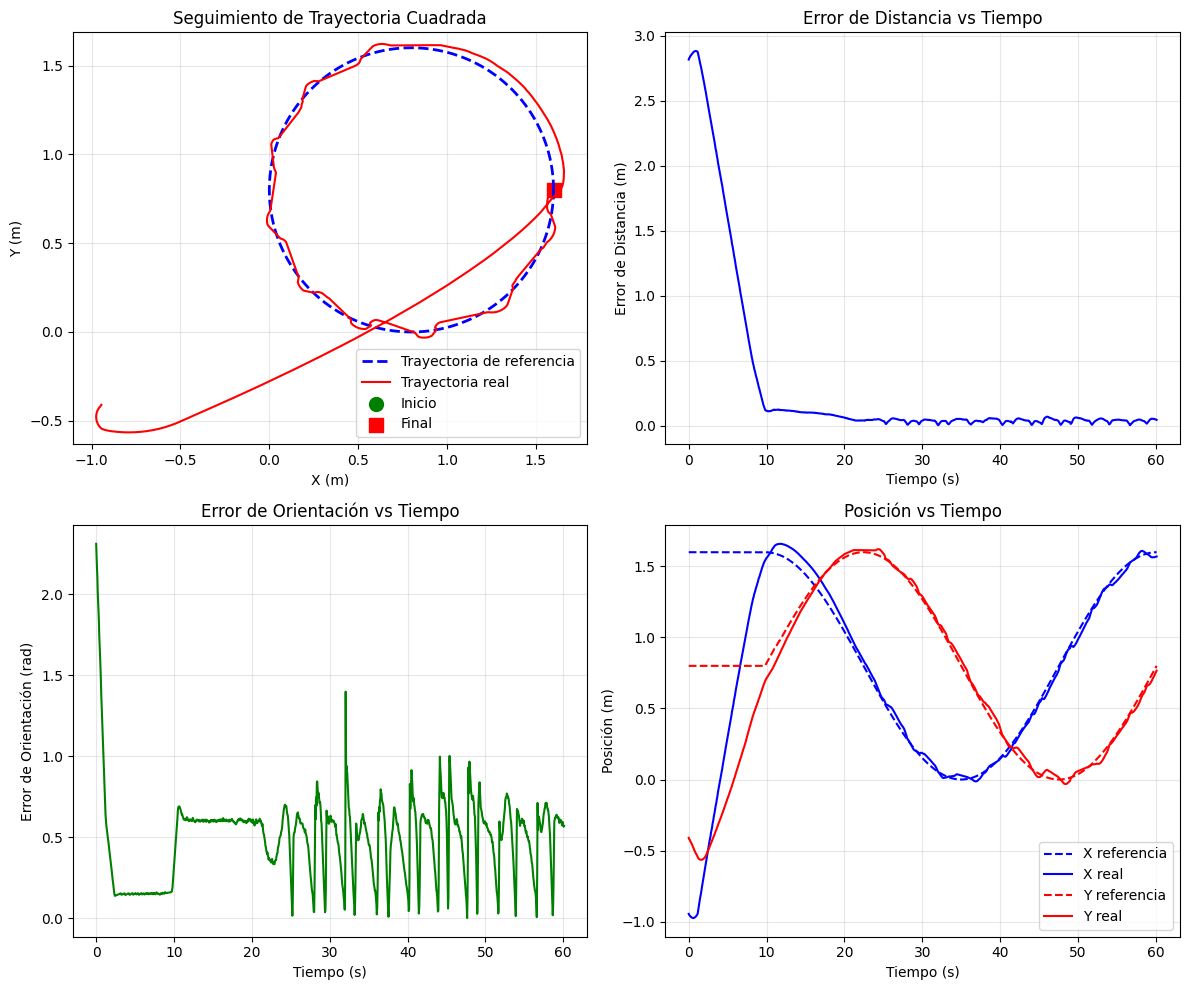


📊 Métricas de Rendimiento:
IAE (Integral of Absolute Error): 18.4816
ISE (Integral of Square Error):   33.9733
TVu (variación de v):             1.7327
TVu (variación de w):             16.0019

📊 Métricas de Rendimiento:
Error medio de distancia: 0.3073 m
Error máximo de distancia: 2.8841 m
Error final de distancia: 0.0452 m
🔌 Conexión cerrada


{'time': [0.0,
  0.05,
  0.1,
  0.15000000000000002,
  0.2,
  0.25,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6000000000000001,
  0.65,
  0.7000000000000001,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.9500000000000001,
  1.0,
  1.05,
  1.1,
  1.1500000000000001,
  1.2000000000000002,
  1.25,
  1.3,
  1.35,
  1.4000000000000001,
  1.4500000000000002,
  1.5,
  1.55,
  1.6,
  1.6500000000000001,
  1.7000000000000002,
  1.75,
  1.8,
  1.85,
  1.9000000000000001,
  1.9500000000000002,
  2.0,
  2.0500000000000003,
  2.1,
  2.15,
  2.2,
  2.25,
  2.3000000000000003,
  2.35,
  2.4000000000000004,
  2.45,
  2.5,
  2.5500000000000003,
  2.6,
  2.6500000000000004,
  2.7,
  2.75,
  2.8000000000000003,
  2.85,
  2.9000000000000004,
  2.95,
  3.0,
  3.0500000000000003,
  3.1,
  3.1500000000000004,
  3.2,
  3.25,
  3.3000000000000003,
  3.35,
  3.4000000000000004,
  3.45,
  3.5,
  3.5500000000000003,
  3.6,
  3.6500000000000004,
  3.7,
  3.75,
  3.8000000000

In [9]:
# FUNCIÓN DE SEGUIMIENTO CON CONTROLADOR OPTIMIZADO

def fuzzy_trajectory_following_optimized(client_id, robot, left_motor, right_motor, xref, yref):
    """
    Seguimiento de trayectoria usando el controlador FINAL OPTIMIZADO
    """
    
    # Parámetros del robot Pioneer P3-DX
    L = 0.381  # distancia entre ruedas [m]
    r = 0.0975  # radio de las ruedas [m]
    
    # Crear el sistema de control difuso OPTIMIZADO
    fuzzy_sim = create_optimized_fuzzy_controller()
    
    # Inicializar streaming de datos
    sim.simxGetObjectPosition(client_id, robot, -1, sim.simx_opmode_streaming)
    sim.simxGetObjectOrientation(client_id, robot, -1, sim.simx_opmode_streaming)
    time.sleep(0.2)
    
    # Variables para almacenar datos
    trajectory_data = {
        'time': [],
        'x_actual': [],
        'y_actual': [],
        'x_ref': [],
        'y_ref': [],
        'error_distance': [],
        'error_orientation': [],
        'v_command' : [],
        'w_command' : [],
    }

    dt = 0.05  # Tiempo de muestreo optimizado
    
    print("🚀 Iniciando seguimiento OPTIMIZADO de trayectoria...")
    
    # Variables de control optimizadas
    current_target_index = 0
    completed_points = 0
    max_iterations = len(xref) * 2  # Reducido aún más
    tolerance = 0.12  # Tolerancia más estricta
    stuck_counter = 0
    last_position = None
    
    iteration = 0
    start_time = time.time()
    
    # BUCLE PRINCIPAL OPTIMIZADO
    while current_target_index < len(xref) and iteration < max_iterations:
        loop_start_time = time.time()
        
        # Obtener posición actual del robot
        pos, orient = get_robot_position(client_id, robot)
        x_actual, y_actual = pos[0], pos[1]
        theta_actual = orient[2]  # orientación en Z (yaw)
        
        # Punto objetivo actual
        x_target = xref[current_target_index]
        y_target = yref[current_target_index]
        
        # Calcular errores
        dx = x_target - x_actual
        dy = y_target - y_actual
        distance_error = np.sqrt(dx**2 + dy**2)
        
        # Verificar si se alcanzó el punto objetivo
        if distance_error < tolerance:
            completed_points += 1
            current_target_index += 1
            stuck_counter = 0
            
            if current_target_index >= len(xref):
                print(f"✅ ¡TRAYECTORIA COMPLETADA! Puntos: {completed_points}/{len(xref)}")
                break
            
            # Actualizar objetivo
            x_target = xref[current_target_index]
            y_target = yref[current_target_index]
            dx = x_target - x_actual
            dy = y_target - y_actual
            distance_error = np.sqrt(dx**2 + dy**2)
        
        # Detectar estancamiento
        if last_position is not None:
            movement = np.sqrt((x_actual - last_position[0])**2 + (y_actual - last_position[1])**2)
            if movement < 0.008:  # Umbral más estricto
                stuck_counter += 1
            else:
                stuck_counter = 0
        
        last_position = (x_actual, y_actual)
        
        # Si está estancado, saltar puntos
        if stuck_counter > 40:  # Reducido de 50 a 40
            print(f"⚠️  Saltando punto {current_target_index} por estancamiento")
            current_target_index = min(current_target_index + 3, len(xref) - 1)
            stuck_counter = 0
            continue
        
        # Calcular ángulo deseado
        theta_desired = np.arctan2(dy, dx)
        orientation_error = normalize_angle(theta_desired - theta_actual)
        
        # Aplicar controlador difuso OPTIMIZADO
        velocity_command, angular_velocity_command = optimized_fuzzy_controller(
            distance_error, orientation_error, fuzzy_sim)
        
        # Suavizado adicional ultra-conservador
        if abs(orientation_error) > np.pi/4:
            velocity_command *= 0.3  # Reducir aún más en giros grandes
        
        # Filtro de suavizado MÁXIMO para velocidad angular
        angular_velocity_command *= 0.7  # Factor de suavizado aumentado
        
        # Cinemática inversa para calcular velocidades de ruedas
        v_left = (velocity_command - (L/2) * angular_velocity_command) / r
        v_right = (velocity_command + (L/2) * angular_velocity_command) / r
        
        # Limitar velocidades de las ruedas ultra-conservadoramente
        max_wheel_speed = 2.5  # Reducido de 3.0 a 2.5
        v_left = max(-max_wheel_speed, min(v_left, max_wheel_speed))
        v_right = max(-max_wheel_speed, min(v_right, max_wheel_speed))
        
        # Aplicar velocidades a los motores
        set_motor_speeds(client_id, left_motor, right_motor, v_left, v_right)
        
        # Almacenar datos para análisis
        current_time = iteration * dt
        trajectory_data['time'].append(current_time)
        trajectory_data['x_actual'].append(x_actual)
        trajectory_data['y_actual'].append(y_actual)
        trajectory_data['x_ref'].append(x_target)
        trajectory_data['y_ref'].append(y_target)
        trajectory_data['error_distance'].append(distance_error)
        trajectory_data['error_orientation'].append(abs(orientation_error))
        trajectory_data['v_command'].append(velocity_command)
        trajectory_data['w_command'].append(angular_velocity_command)
    
        
        # Información de depuración cada 50 iteraciones
        if iteration % 50 == 0:
            progress = (current_target_index / len(xref)) * 100
            print(f"Paso {iteration}: Punto {current_target_index}/{len(xref)} ({progress:.1f}%) - "
                  f"Pos=({x_actual:.3f}, {y_actual:.3f}), "
                  f"Error={distance_error:.3f}m, Ang={orientation_error:.3f}rad")
        
        # Mantener frecuencia de control
        elapsed = time.time() - loop_start_time
        if elapsed < dt:
            time.sleep(dt - elapsed)
        
        iteration += 1
    
    # Detener robot al final
    set_motor_speeds(client_id, left_motor, right_motor, 0, 0)
    
    total_time = time.time() - start_time
    completion_rate = (completed_points / len(xref)) * 100
    
    print(f"\n🏁 RESULTADO FINAL (OPTIMIZADO):")
    print(f"   Tiempo total: {total_time:.2f} segundos")
    print(f"   Puntos completados: {completed_points}/{len(xref)} ({completion_rate:.1f}%)")
    print(f"   Iteraciones totales: {iteration}")
    
    if completion_rate >= 90:
        print("🌟 ¡EXCELENTE! Trayectoria completada con controlador optimizado")
    elif completion_rate >= 75:
        print("✅ ¡BUENO! Mayoría de la trayectoria completada")
    else:
        print("⚠️  Trayectoria parcialmente completada")
    
    return trajectory_data

def main_fuzzy_optimizado(tipo='cuadrado', **params):
    """
    Función principal para usar el controlador OPTIMIZADO
    """
    try:
        print(f"🎯 Iniciando control OPTIMIZADO con trayectoria {tipo.upper()}...")
        
        # Conectar a CoppeliaSim
        client_id = connect_to_coppelia()
        
        # Iniciar simulación
        sim.simxStartSimulation(client_id, sim.simx_opmode_oneshot)
        time.sleep(2.0)
        
        # Obtener handles
        left_motor, right_motor, robot = get_handles(client_id)
        
        # Generar trayectoria según el tipo
        velTrayectoria = params.get('velTrayectoria', 0.05)  # Aún más lenta
        
        if tipo.lower() == 'cuadrado':
            L = params.get('L', 1.5)  # Más pequeño
            A = params.get('A', 1.5)
            xref, yref = trayectoria(L, A, velTrayectoria)
            print(f"📐 Trayectoria cuadrada OPTIMIZADA: {L}x{A}m, {len(xref)} puntos")
            
        elif tipo.lower() == 'circular':
            radio = params.get('radio', 0.8)  # Más pequeño
            cx = params.get('cx', radio)
            cy = params.get('cy', radio)
            xref, yref = trayectoria_circular(radio, velTrayectoria, cx, cy)
            print(f"⭕ Trayectoria circular OPTIMIZADA: radio {radio}m, {len(xref)} puntos")
            
        elif tipo.lower() == 'lineal':
            x0 = params.get('x0', 0)
            y0 = params.get('y0', 0)
            x1 = params.get('x1', 1.0)  # Más corto
            y1 = params.get('y1', 1.0)
            xref, yref = trayectoria_lineal(x0, y0, x1, y1, velTrayectoria)
            print(f"📏 Trayectoria lineal OPTIMIZADA: ({x0},{y0}) → ({x1},{y1}), {len(xref)} puntos")
        
        # Verificar posición inicial
        pos, orient = get_robot_position(client_id, robot)
        x_inicial, y_inicial = pos[0], pos[1]
        print(f"📍 Robot en: ({x_inicial:.3f}, {y_inicial:.3f})")
        print(f"📍 Primer punto: ({xref[0]:.3f}, {yref[0]:.3f})")
        
        # Ejecutar seguimiento OPTIMIZADO
        trajectory_data = fuzzy_trajectory_following_optimized(client_id, robot, left_motor, right_motor, xref, yref)
        
        
        # Análisis gráfico
        plot_results(trajectory_data, xref, yref)
        
        return trajectory_data
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    finally:
        try:
            sim.simxStopSimulation(client_id, sim.simx_opmode_blocking)
            time.sleep(1)
            sim.simxFinish(client_id)
            print("🔌 Conexión cerrada")
        except:
            pass

print("✅ Funciones del controlador OPTIMIZADO listas para usar!")
print("💡 Uso: main_fuzzy_optimizado('cuadrado') o main_fuzzy_optimizado('circular') o main_fuzzy_optimizado('lineal')")
main_fuzzy_optimizado('circular')

🎯 Iniciando control OPTIMIZADO con trayectoria CUADRADO...
✅ Conectado a CoppeliaSim
📐 Trayectoria cuadrada OPTIMIZADA: 1.5x1.5m, 1200 puntos
📍 Robot en: (0.000, 0.000)
📍 Primer punto: (0.000, 0.000)
🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con 19 reglas
✅ Configurado para máxima suavidad y precisión en líneas rectas
🚀 Iniciando seguimiento OPTIMIZADO de trayectoria...
Paso 0: Punto 0/1200 (0.0%) - Pos=(-0.926, -0.388), Error=1.004m, Ang=2.473rad
Paso 50: Punto 0/1200 (0.0%) - Pos=(-0.609, -0.528), Error=0.806m, Ang=0.382rad
Paso 100: Punto 0/1200 (0.0%) - Pos=(-0.078, -0.141), Error=0.161m, Ang=0.160rad
Paso 150: Punto 44/1200 (3.7%) - Pos=(0.126, 0.057), Error=0.111m, Ang=-0.594rad
Paso 200: Punto 94/1200 (7.8%) - Pos=(0.395, 0.055), Error=0.093m, Ang=-0.587rad
Paso 250: Punto 144/1200 (12.0%) - Pos=(0.667, 0.038), Error=0.065m, Ang=-0.553rad
Paso 300: Punto 194/1200 (16.2%) - Pos=(0.932, 0.018), Error=0.042m, Ang=-0.358rad
Paso 350: Punto 244/1200 (20.3%) - Pos=(1.210, -0.018), E

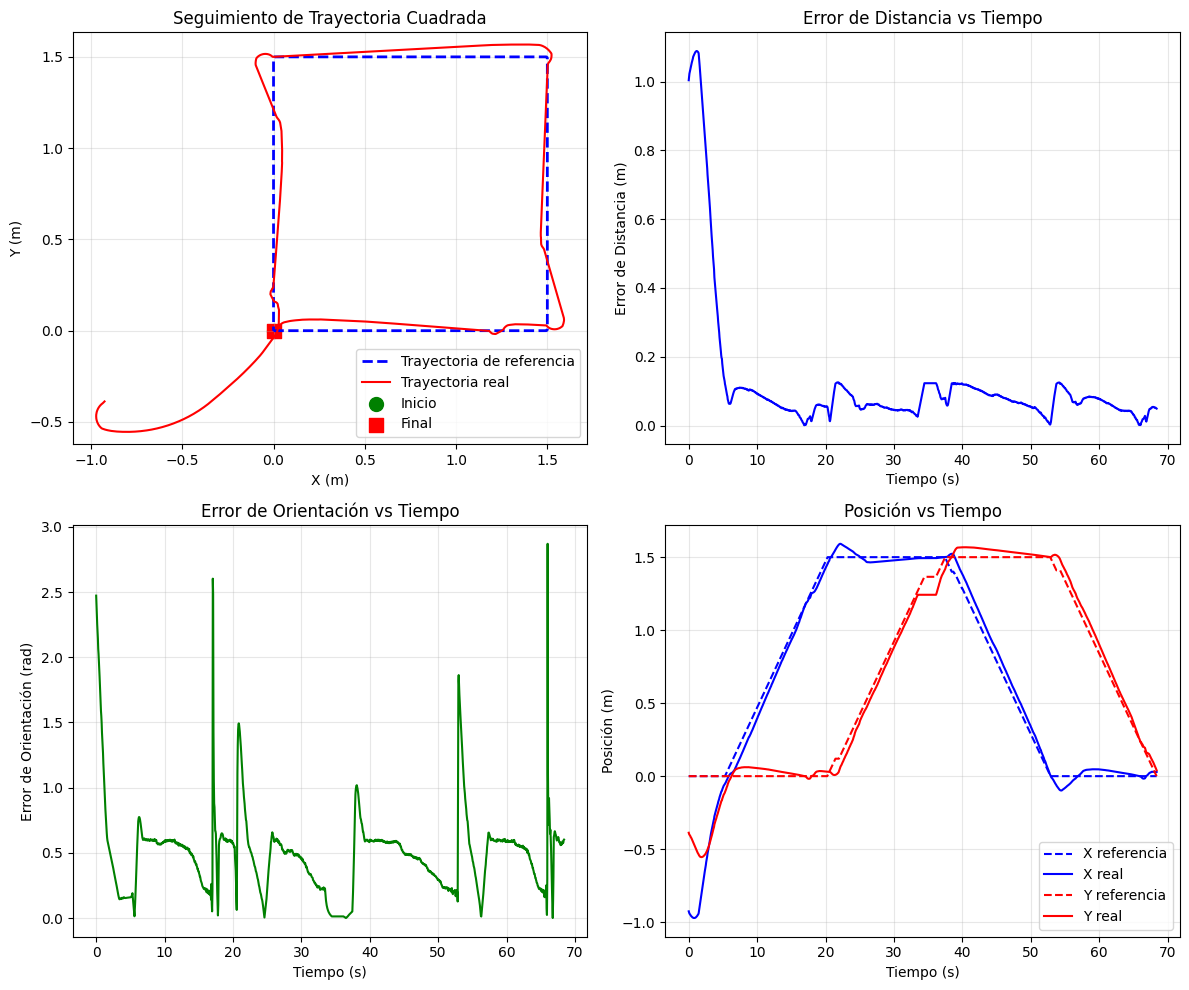


📊 Métricas de Rendimiento:
IAE (Integral of Absolute Error): 8.1706
ISE (Integral of Square Error):   3.6030
TVu (variación de v):             1.2552
TVu (variación de w):             7.6902

📊 Métricas de Rendimiento:
Error medio de distancia: 0.1194 m
Error máximo de distancia: 1.0886 m
Error final de distancia: 0.0495 m
🔌 Conexión cerrada


{'time': [0.0,
  0.05,
  0.1,
  0.15000000000000002,
  0.2,
  0.25,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6000000000000001,
  0.65,
  0.7000000000000001,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.9500000000000001,
  1.0,
  1.05,
  1.1,
  1.1500000000000001,
  1.2000000000000002,
  1.25,
  1.3,
  1.35,
  1.4000000000000001,
  1.4500000000000002,
  1.5,
  1.55,
  1.6,
  1.6500000000000001,
  1.7000000000000002,
  1.75,
  1.8,
  1.85,
  1.9000000000000001,
  1.9500000000000002,
  2.0,
  2.0500000000000003,
  2.1,
  2.15,
  2.2,
  2.25,
  2.3000000000000003,
  2.35,
  2.4000000000000004,
  2.45,
  2.5,
  2.5500000000000003,
  2.6,
  2.6500000000000004,
  2.7,
  2.75,
  2.8000000000000003,
  2.85,
  2.9000000000000004,
  2.95,
  3.0,
  3.0500000000000003,
  3.1,
  3.1500000000000004,
  3.2,
  3.25,
  3.3000000000000003,
  3.35,
  3.4000000000000004,
  3.45,
  3.5,
  3.5500000000000003,
  3.6,
  3.6500000000000004,
  3.7,
  3.75,
  3.8000000000

In [12]:
main_fuzzy_optimizado('cuadrado')

🎯 Iniciando control OPTIMIZADO con trayectoria LINEAL...
✅ Conectado a CoppeliaSim
📏 Trayectoria lineal OPTIMIZADA: (0,0) → (1.0,1.0), 283 puntos
📍 Robot en: (0.000, 0.000)
📍 Primer punto: (0.000, 0.000)
🎯 CONTROLADOR FUZZY FINAL OPTIMIZADO creado con 19 reglas
✅ Configurado para máxima suavidad y precisión en líneas rectas
🚀 Iniciando seguimiento OPTIMIZADO de trayectoria...
Paso 0: Punto 0/283 (0.0%) - Pos=(-0.934, -0.396), Error=1.015m, Ang=2.393rad
Paso 50: Punto 0/283 (0.0%) - Pos=(-0.593, -0.522), Error=0.790m, Ang=0.355rad
Paso 100: Punto 0/283 (0.0%) - Pos=(-0.081, -0.143), Error=0.164m, Ang=0.160rad
Paso 150: Punto 45/283 (15.9%) - Pos=(0.104, 0.101), Error=0.081m, Ang=-0.114rad
Paso 200: Punto 95/283 (33.6%) - Pos=(0.263, 0.318), Error=0.076m, Ang=-0.606rad
Paso 250: Punto 145/283 (51.2%) - Pos=(0.451, 0.504), Error=0.064m, Ang=-0.572rad
Paso 300: Punto 195/283 (68.9%) - Pos=(0.647, 0.681), Error=0.046m, Ang=-0.495rad
Paso 350: Punto 245/283 (86.6%) - Pos=(0.836, 0.851), Erro

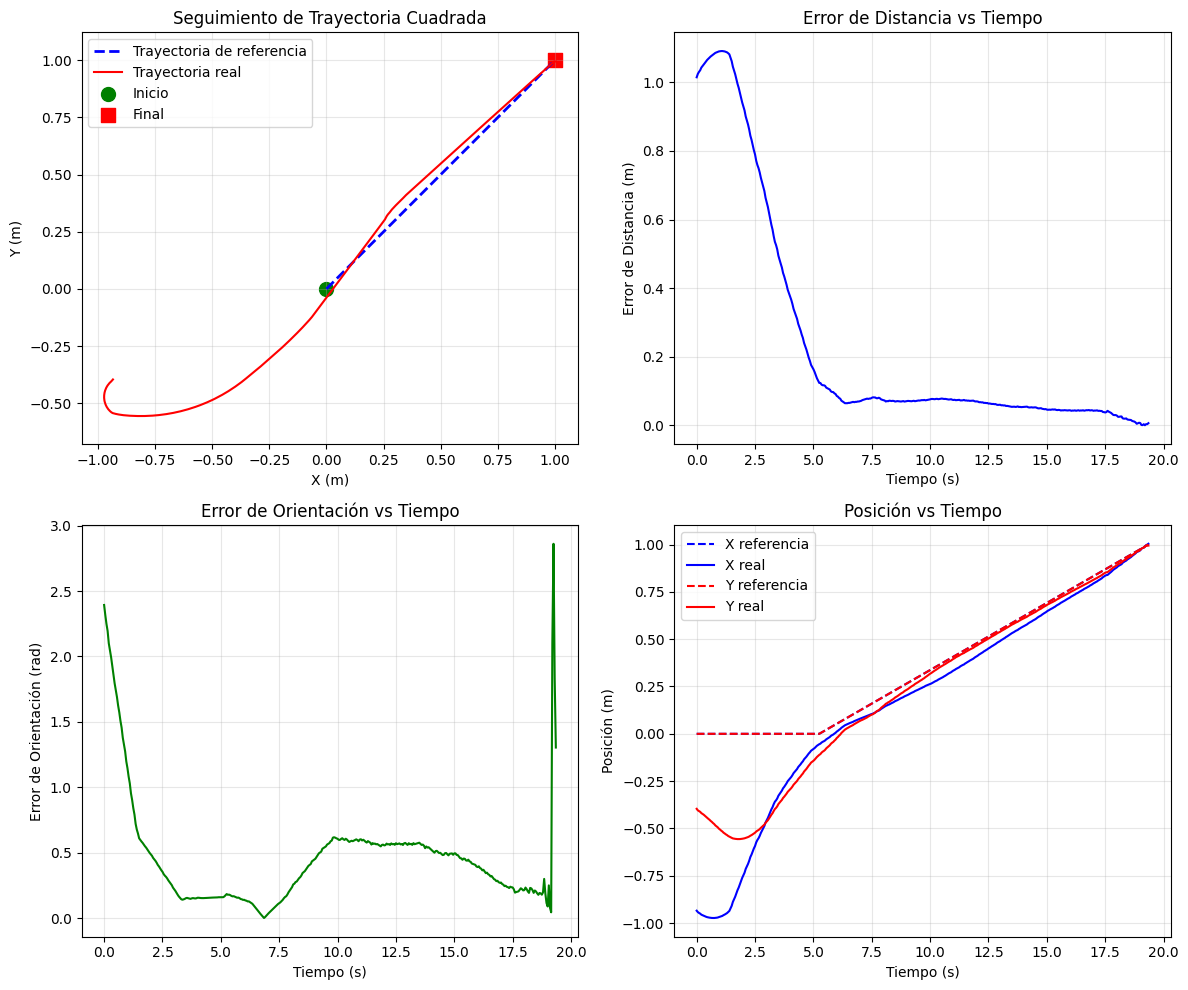


📊 Métricas de Rendimiento:
IAE (Integral of Absolute Error): 4.5627
ISE (Integral of Square Error):   3.2713
TVu (variación de v):             0.4105
TVu (variación de w):             1.2746

📊 Métricas de Rendimiento:
Error medio de distancia: 0.2352 m
Error máximo de distancia: 1.0913 m
Error final de distancia: 0.0067 m
🔌 Conexión cerrada


{'time': [0.0,
  0.05,
  0.1,
  0.15000000000000002,
  0.2,
  0.25,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6000000000000001,
  0.65,
  0.7000000000000001,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.9500000000000001,
  1.0,
  1.05,
  1.1,
  1.1500000000000001,
  1.2000000000000002,
  1.25,
  1.3,
  1.35,
  1.4000000000000001,
  1.4500000000000002,
  1.5,
  1.55,
  1.6,
  1.6500000000000001,
  1.7000000000000002,
  1.75,
  1.8,
  1.85,
  1.9000000000000001,
  1.9500000000000002,
  2.0,
  2.0500000000000003,
  2.1,
  2.15,
  2.2,
  2.25,
  2.3000000000000003,
  2.35,
  2.4000000000000004,
  2.45,
  2.5,
  2.5500000000000003,
  2.6,
  2.6500000000000004,
  2.7,
  2.75,
  2.8000000000000003,
  2.85,
  2.9000000000000004,
  2.95,
  3.0,
  3.0500000000000003,
  3.1,
  3.1500000000000004,
  3.2,
  3.25,
  3.3000000000000003,
  3.35,
  3.4000000000000004,
  3.45,
  3.5,
  3.5500000000000003,
  3.6,
  3.6500000000000004,
  3.7,
  3.75,
  3.8000000000

In [14]:
main_fuzzy_optimizado('lineal')